## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import pandas as pd

In [13]:
pd.set_option("display.max_columns", 99)

In [5]:
dp = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/processed/").absolute()
dp.exists()

True

In [112]:
tmp = Path("/Users/felix/tmp/lcd/").absolute()
tmp.mkdir(exist_ok=True, parents=True)
(tmp/"slices").mkdir(exist_ok=True)
(tmp/"overlays").mkdir(exist_ok=True)
(tmp/"nodules").mkdir(exist_ok=True)

## Prepare metadata

In [7]:
scans = pd.read_csv(dp/"meta/scans.csv", index_col="PatientID")
nods = pd.read_csv(dp/"meta/nodules.csv", index_col="PatientID")
print(scans.shape)
print(nods.shape)

(1010, 18)
(2625, 22)


In [8]:
case_id = "LIDC-IDRI-0186"

In [9]:
case_nods = nods.loc[case_id]
case_nods.shape

(5, 22)

In [14]:
case_nods.sort_values("Volume", ascending=False)

,StudyID,SeriesID,NoduleID,NumAnnotations,Diameter,SurfaceArea,Volume,Malignancy,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,InternalStructure,Subtlety,x_start,x_stop,y_start,y_stop,z_start,z_stop
PatientID,,,,,,,,,,,,,,,,,,,,,,
LIDC-IDRI-0186,1.3.6.1.4.1.14519.5.2.1.6279.6001.300568323537...,1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718...,3,2,31.353731,3097.289971,7943.094052,3,5,4,3,3,4,6,4,5,268,323,172,219,111,120
LIDC-IDRI-0186,1.3.6.1.4.1.14519.5.2.1.6279.6001.300568323537...,1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718...,4,4,17.445504,881.249009,1382.700205,5,5,4,3,4,4,6,1,5,293,328,329,369,117,123
LIDC-IDRI-0186,1.3.6.1.4.1.14519.5.2.1.6279.6001.300568323537...,1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718...,1,1,12.695788,412.727257,550.431778,2,1,1,1,2,5,6,1,1,209,228,407,424,77,81
LIDC-IDRI-0186,1.3.6.1.4.1.14519.5.2.1.6279.6001.300568323537...,1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718...,2,2,6.485468,100.715517,90.353896,3,5,2,3,3,4,6,1,4,204,213,135,146,107,110
LIDC-IDRI-0186,1.3.6.1.4.1.14519.5.2.1.6279.6001.300568323537...,1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718...,0,2,5.714748,88.608536,87.238244,1,5,1,3,5,5,3,1,5,121,131,335,344,75,77


## Prepare scan slices

### Load image and mask

In [123]:
from lung_cancer_detection.data.reader import LIDCReader
from monai.transforms import Compose, LoadImaged, ScaleIntensityd, Spacingd, AddChanneld
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.pyplot import cm
from tqdm import tqdm

In [64]:
def create_2d_img(img, z, window=(-600, 1500)):
    # clip pixel values to desired window
    level, width = window
    img = np.clip(img, level-(width/2), level+(width/2))
    # normalize pixel values to 0-1 range
    img_min = img.min()
    img_max = img.max()
    img = (img - img_min) / (img_max - img_min)
    # convert to Pillow image for display
    img_slice = img[:, :, z]
    pil_img = Image.fromarray(np.uint8(cm.gray(img_slice)*255))
    return pil_img.convert('RGBA')

def create_2d_mask(mask, z):
    ms = (mask[:,:,z]*96).astype(np.uint8)
    mi = Image.fromarray(ms, mode="L")
    return mi

def create_2d_overlay(img):
    arr = np.zeros((img.shape[0], img.shape[1], 4)).astype(np.uint8)
    arr[:,:,1] = 128
    arr[:,:,3] = 128
    overlay = Image.fromarray(arr, mode="RGBA")
    return overlay

In [51]:
dd = {"image": f"images/{case_id}.npy", "label": f"masks/{case_id}.npy"}

In [52]:
loader = LoadImaged(keys=("image", "label"))
loader.register(LIDCReader(dp))

In [53]:
dd = loader(dd)
print(dd["image"].shape)
print(dd["label"].shape)

(512, 512, 137)
(512, 512, 137)


### Save raw image slices

In [63]:
for z in tqdm(range(dd["image"].shape[-1])):
    img = create_2d_img(dd["image"], z)
    img.save(tmp/f"slices/slice_{z:03d}.png")

100%|██████████| 137/137 [01:02<00:00,  2.18it/s]


### Save image slices with overlay

In [73]:
overlay = create_2d_overlay(dd["image"])
for z in tqdm(range(dd["image"].shape[-1])):
    img = create_2d_img(dd["image"], z)
    mask = create_2d_mask(dd["label"], z)    
    output_image = Image.composite(overlay, img, mask)
    output_image.save(tmp/f"overlays/slice_{z:03d}.png")

100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


## Prepare nodule slices

In [105]:
dd = [{"image": f"nodules/{case_id}_{i}.npy"} for i, mal in zip(list(case_nods.NoduleID), list(case_nods.Malignancy))]
dd

[{'image': 'nodules/LIDC-IDRI-0186_0.npy'},
 {'image': 'nodules/LIDC-IDRI-0186_1.npy'},
 {'image': 'nodules/LIDC-IDRI-0186_2.npy'},
 {'image': 'nodules/LIDC-IDRI-0186_3.npy'},
 {'image': 'nodules/LIDC-IDRI-0186_4.npy'}]

In [106]:
reader = LIDCReader(dp, nodule_mode=True)
loader = LoadImaged(keys=["image"], reader=reader)

In [125]:
for i in tqdm(range(len(dd))):
    d = loader(dd[i])
    channel = AddChanneld(keys=["image"])
    d = channel(d)
    spacing_before = d["image_meta_dict"]["spacing"]
    spacing_after = (spacing_before[0]/5, spacing_before[1]/5, spacing_before[2])
    spacer = Spacingd(keys=["image"], pixdim=spacing_after, mode="bilinear")
    d = spacer(d)
    arr = d["image"][0]
    node_path = tmp/f"nodules/nodule_{i}"
    node_path.mkdir(exist_ok=True)
    for z in range(arr.shape[-1]):
        img = create_2d_img(arr, z)
        img.save(node_path/f"slice_{z:02d}.png")

100%|██████████| 5/5 [01:03<00:00, 12.70s/it]


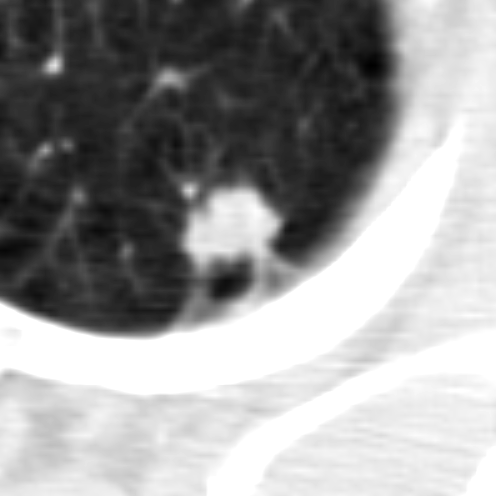

In [120]:
create_2d_img(d["image"][0], 30)